# Project Navigation Guidelines

In [ ]:
'''
===================================================
Notebook naming convention for FindMeInside (FMI)
===================================================
Notebook name: [FMI] <Coord/Label> Alg - Exp<experiment_number>, Trial<trial_number>

===================================================
Folder/File naming convention
===================================================
# Folder categorised by Experiment (except Testing folder)
Folder name: Experiment<Experiment_number>

# Each Folder has N files.
# A file is either a 1)Unprocessed Dataset, 2)Processed Dataset, 3)Results dataset, 4) Notebook file
# Each experiment has N trials. (Adjustments to parameters/algorithm are made in each trial)
Files in folder will be named accordingly...

- Raw data point:             E<experiment_number>_Label/Location<location_identifier>_<date>v<version_number>
-- e.g. E1_LabelA_230320v1
- Raw data collection:        E<experiment_number>_All_Raw_<date>v<version_number>
-- e.g. E1_All_Raw_230320v1
- Processed data (if any):    E<experiment_number>_All_Proc_<date>v<version_number>
-- e.g. E1_All_Proc_230320v1
- Resampled data (if any):    E<experiment_number>_resampled_t<trial_number>
-- e.g. E1_resampled_t1
- Results data:               E<experiment_number>_<algorithm>_t<trial_number>_k<number_of_neighbours>
-- e.g. E1_KNN_t1_k37

===================================================
List of experiment(s) & description(s)
===================================================
>> Experiment 1 (Exp1) :11 Sensors {1, ..., 11} , 4 Location Labels {A,B,C,D}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 2 (Exp2) :11 Sensors {1, ..., 11} , 4 Location Coords {(x_A, y_A), ... (x_D, y_D)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 3 (Exp3) : 12 Sensors {0x1, ..., 0xC} , 12 Location Label {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 4 (Exp4) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 5 (Exp5) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Averaged 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 6 (Exp6) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Resampled 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 7 (Exp7) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via FindMeInside Phone App
>> Trained Data: Sampled 12-Sensor RSSI Signature for 12 Locations (100-x%)
>> Tested Data: Sampled 12-Sensor RSSI Signature (x%)
>> Output: Label Coords (Label Model)

>> Experiment 8 (Exp8) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via FindMeInside Phone App
>> Trained Data: Sampled 12-Sensor RSSI Signature for 12 Locations (100-x%)
>> Tested Data: Sampled 12-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

'''
None

# Trial Description

In [1]:
exp = 4
trial = 6
'''
Trial 6
Algorithms use calcLocation mechanic
Resampling done within time period of 2s.
Distance weighting : 1/ (distance^2)
Location output in INTEGER only
'''
None

# Core Libraries

In [2]:
import pandas as pd #from pandas import read_csv, pivot_table
import numpy as np
import math
import operator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# [Exploratory Data Analysis]

# Prepare/Load Relevant Dataset

In [3]:
# Read csv file into dataframe.
csvfile = pd.read_csv('E4_All_Proc_230320v1.csv')
relDf = pd.DataFrame(csvfile)
# print(relDf)
relDf.columns = relDf.columns.str.strip() #strip unintended whitespaces

# print("Columns: ", relDf.columns)
relDf = relDf[['Date','Time', 'ID2', 'RSSI', 'Location']] #select relevant columns
# df = df.drop(columns=['Type', 'ID0', 'ID1', 'Sensor Data', 'Temperature', 'Humidity', 'Raw Data'])
print(relDf)

          Date       Time      ID2  RSSI Location
0      16/3/20   15:14:49   0x0001   192      1,1
1      16/3/20   15:14:49   0x0003   177      1,1
2      16/3/20   15:14:49   0x0004   179      1,1
3      16/3/20   15:14:50   0x0002   189      1,1
4      16/3/20   15:14:51   0x0008   177      1,1
...        ...        ...      ...   ...      ...
52882  19/3/20   15:48:51   0x0009   177    19,13
52883  19/3/20   15:48:51   0x0004   177    19,13
52884  19/3/20   15:48:51   0x0002   177    19,13
52885  19/3/20   15:48:51   0x000B   189    19,13
52886  19/3/20   15:48:51   0x0005   177    19,13

[52887 rows x 5 columns]


# Resample/Reshape Dataset

In [4]:
# Preparation for Date/Time Differences
# ----------------------------------------

# Combine date and time to datetime
readings = relDf.copy()
readings['Datetime'] = pd.to_datetime(readings['Date'].apply(str)+' '+readings['Time']) #create new Datetime field
dateTime = readings['Datetime']
readings = readings.drop(columns=['Datetime'])
readings.insert(0, 'Datetime', dateTime)
readings = readings.drop(columns=['Date','Time'])
readings.tail()

from datetime import datetime as dt
earliestDate = readings.Datetime.dt.date.min()
print(readings.Datetime.dt.date.iloc[-1])
print(earliestDate - readings.Datetime.dt.date.iloc[-1])

# Function that expresses timestamps in seconds.
def time_to_sec(timeArray):
    timeSecArray = []
    for i in range(len(timeArray)):
        seconds = (timeArray[i].hour * 60 + timeArray[i].minute) * 60 + timeArray[i].second
        timeSecArray.append(seconds)
    return(timeSecArray)

# Function that calculates day difference between dates in seconds
def date_to_sec(dateArray):
    dateSecArray = []
    for i in range(len(dateArray)):
        dayDiff = dateArray[i] - earliestDate
        dateSecArray.append(dayDiff.total_seconds())
    print(i)
    return(dateSecArray)


readings['DateSec'] = date_to_sec(readings.Datetime.dt.date)
readings['TimeSec'] = time_to_sec(readings.Datetime.dt.time)
readings['DatetimeSec'] = readings['DateSec'] + readings['TimeSec']
readings = readings[['DatetimeSec', 'ID2', 'RSSI', 'Location']]
print(readings.head(15))

# pd.set_option('display.max_columns', 10)
# pd.set_option('display.min_rows', 50)
# pd.set_option('display.width', 500)

readings.DatetimeSec = (readings.DatetimeSec - readings.DatetimeSec.min()) // 2
time_diff_btw_rows = readings.DatetimeSec.diff().fillna(0)
print(time_diff_btw_rows)
time_diff_btw_rows -= (time_diff_btw_rows > 1) & (readings.DatetimeSec % 2 > 0)
readings.DatetimeSec -= (time_diff_btw_rows - 1).clip(lower=0).cumsum()
readings.ID2 = readings.ID2.transform(lambda hexadecimal: int(hexadecimal, 16))
resampled_readings = readings.groupby(["DatetimeSec", "Location", "ID2"]).mean().reset_index()
pivoted_readings = pd.pivot_table(resampled_readings, values="RSSI", columns=["ID2"], index=["DatetimeSec", "Location"]).fillna(0)

writeFile = True
if (writeFile == True):
    pivoted_readings.to_csv('E4_resampled_T1.csv')
    print("FILE WRITTEN")

pivoted_readings.head()

2020-03-19
-3 days, 0:00:00
52886
    DatetimeSec      ID2  RSSI Location
0       54889.0   0x0001   192      1,1
1       54889.0   0x0003   177      1,1
2       54889.0   0x0004   179      1,1
3       54890.0   0x0002   189      1,1
4       54891.0   0x0008   177      1,1
5       54891.0   0x0005   177      1,1
6       54891.0   0x0001   193      1,1
7       54891.0   0x000B   177      1,1
8       54891.0   0x0009   177      1,1
9       54891.0   0x0003   180      1,1
10      54892.0   0x0002   182      1,1
11      54893.0   0x0008   177      1,1
12      54893.0   0x0001   191      1,1
13      54893.0   0x0003   185      1,1
14      54893.0   0x000C   177      1,1
0        0.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
52882    0.0
52883    0.0
52884    0.0
52885    0.0
52886    0.0
Name: DatetimeSec, Length: 52887, dtype: float64
FILE WRITTEN


,ID2,1,2,3,4,5,6,7,8,9,10,11,12
DatetimeSec,Location,,,,,,,,,,,,
0.0,"1,1",192.0,189.0,177.0,179.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,"1,1",193.0,182.0,180.0,0.0,177.0,0.0,0.0,177.0,177.0,0.0,177.0,0.0
2.0,"1,1",191.0,191.0,185.0,184.0,177.0,177.0,0.0,177.0,0.0,177.0,0.0,177.0
3.0,"1,1",195.0,192.0,184.0,182.0,177.0,177.0,177.0,177.0,0.0,0.0,177.0,177.0
4.0,"1,1",194.0,193.0,184.0,187.0,0.0,0.0,177.0,178.0,0.0,0.0,0.0,177.0


In [5]:
resampledDS = pd.read_csv('E4_resampled_T1.csv')
tempSeries = resampledDS['Location']
resampledDS = resampledDS.drop(columns=['Location', 'DatetimeSec'])
resampledDS["Location"] = tempSeries
resampledDS.head()
lastIndex = len(resampledDS)
numCol = len(resampledDS.columns)

ips_data = resampledDS.iloc[:lastIndex, :numCol-1]
# print(ips_data)
ips_labels = resampledDS.iloc[:lastIndex, numCol-1:]
# print(ips_labels)


# #dataset.iloc[rowrange, columnrange]
X = ips_data.to_numpy()
y = ips_labels.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True,test_size=0.3, random_state = 10) 
y_train = y_train.reshape(len(y_train),)

k_value_rootN = math.ceil(math.sqrt(len(X_train)))
print("estimated k value: ", k_value_rootN)
print("X_test: ", X_test)
print("y_test: ", y_test)
print("y_train: ", y_train)

estimated k value:  63
X_test:  [[177. 186. 191. ...   0. 177. 182.]
 [  0.   0.   0. ... 195.   0. 191.]
 [  0. 177. 177. ...   0. 189. 183.]
 ...
 [  0. 177.   0. ... 184. 188.   0.]
 [  0. 179.   0. ...   0. 193. 186.]
 [  0. 177. 177. ... 178. 177. 192.]]
y_test:  [['1,13']
 ['19,1']
 ['13,7']
 ...
 ['13,1']
 ['13,7']
 ['13,13']]
y_train:  ['19,13' '13,7' '19,1' ... '1,13' '19,1' '1,13']


# Parameter Optimisation

In [6]:
X = preprocessing.normalize(X)
y = y.reshape(len(y),)
k_range = list(range(1, 38))
# print(k_range)

classifier = KNeighborsClassifier(n_neighbors=3)
# classifier.fit(X_train, y_train)

param_grid = dict(n_neighbors=k_range)
print(param_grid)

grid = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy')

grid.fit(X,y)
print(grid.best_estimator_)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


In [ ]:

classifier = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test) 
y_train_pred = classifier.predict(X_train)

print("KNN Train Accuracy:", accuracy_score(y_train, y_train_pred)* 100, "%")
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred) * 100, "%")
print(classification_report(y_test, y_pred))

# KNN Algorithm - Distance Calculation

In [7]:
#Function calculates euclidean distance between two n-dimensional data instances 
def euclideanDistance(instance1, instance2):
    #handles if instances are lists or tuples:
    instance1 = np.array(instance1) 
    instance2 = np.array(instance2)
    
    '''
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html
    uses 2-norm frobenius norm and returns euclidean distance
    '''
    return np.linalg.norm(instance1 - instance2) #euclidean distance

# KNN Algorithm - Determining Neighbours

In [8]:
#Function finds nearest neighbours; nearest -> smallest euclidean distance
def get_neighbors(training_set, 
                  labels, 
                  test_instance, 
                  k, 
                  distance=euclideanDistance):
    """
    get_neighbors calculates a list of the k nearest neighbors
    of an instance 'test_instance'.
    The list neighbors contains 3-tuples with  
    (index, dist, label)
    where
    index    is the index from the training_set, 
    dist     is the distance between the test_instance and the 
             instance training_set[index]
    distance is a reference to a function used to calculate the 
             distances
    """
    distances = [] #empty distance array
    
    #calculates euclidean distance between test_instance and ALL other instances in training_set
    for index in range(len(training_set)):
        dist = euclideanDistance(test_instance, training_set[index])
        distances.append((training_set[index], dist, labels[index]))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors # The list neighbors contains 3-tuples with (index, dist, label)

In [9]:
# Get Neighbours
outArray = []
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_rootN, 
                              distance=euclideanDistance)
#     print(i,
#           X_test[i],
#           y_test[i],
#           neighbors)
    
    outArray.append([i,
          X_test[i],
          y_test[i],
          neighbors])

out_df = pd.DataFrame(outArray, columns=['i', 'X_test', 'y_test', 'neighbours'])
out_df.head()
# out_df.tail()

,i,X_test,y_test,neighbours
0,0,"[177.0, 186.0, 191.0, 177.0, 0.0, 181.0, 0.0, ...","[1,13]","[([177.0, 186.0, 191.0, 177.0, 0.0, 181.0, 0.0..."
1,1,"[0.0, 0.0, 0.0, 184.0, 0.0, 177.0, 189.0, 181....","[19,1]","[([0.0, 0.0, 0.0, 178.0, 0.0, 177.0, 187.0, 17..."
2,2,"[0.0, 177.0, 177.0, 177.0, 0.0, 181.0, 188.0, ...","[13,7]","[([0.0, 177.0, 177.0, 178.0, 0.0, 181.0, 185.5..."
3,3,"[0.0, 177.0, 177.0, 177.0, 182.0, 181.0, 188.0...","[13,7]","[([0.0, 177.0, 177.0, 177.0, 182.0, 181.0, 187..."
4,4,"[0.0, 0.0, 179.0, 0.0, 178.0, 179.0, 179.0, 18...","[19,13]","[([0.0, 0.0, 178.0, 0.0, 177.0, 179.0, 178.0, ..."


In [12]:
from collections import Counter
#LOC: outputs for each [x,y] in label, 
#     where (x_n1, y_n1) rep x and y coord of 1st neighbour resp
#     x_out = sum(x_n1, ... x_N) / N, where total neighbours = N
def calcLocation(neighbours): 
    x_out = 0
    y_out = 0
    totalNeighbours = len(neighbours)
    for neighbour in neighbours:
        # handle label (str) to tuple(int, int)
        labeltuple = neighbour[2]
        labeltuple = tuple(map(int, labeltuple.split(',')))
#         print("neighbour label: ", labeltuple)
        x_nb = labeltuple[0]
        y_nb = labeltuple[1]
#         print("x_nb: ", x_nb)
#         print("y_nb: ", y_nb)
        x_out += x_nb
        y_out += y_nb
#         print("x_out: ", x_out)
#         print("y_out: ", y_out)
    return (np.floor( (x_out/totalNeighbours) + 0.5 ) , 
            np.floor( (y_out/totalNeighbours) + 0.5 ) )

In [14]:
print("NON-WEIGHTED POSITION KNN\n")
k_value_knn = k_value_rootN
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
    print("test location: ", testPosTuple)
    print("calculalated location: ", calcLocation(neighbors))
    print("distance error: ", euclideanDistance(testPosTuple, calcLocation(neighbors)))
    print("----------------------------")

NON-WEIGHTED POSITION KNN

test location:  (1, 13)
calculalated location:  (2.0, 13.0)
distance error:  1.0
----------------------------
test location:  (19, 1)
calculalated location:  (18.0, 3.0)
distance error:  2.23606797749979
----------------------------
test location:  (13, 7)
calculalated location:  (14.0, 10.0)
distance error:  3.1622776601683795
----------------------------
test location:  (13, 7)
calculalated location:  (14.0, 9.0)
distance error:  2.23606797749979
----------------------------
test location:  (19, 13)
calculalated location:  (18.0, 9.0)
distance error:  4.123105625617661
----------------------------


In [19]:
k_value_knn = k_value_rootN // 2 // 2
writeKNN = True
fileNameKNN = 'E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(k_value_knn)+'.csv'
resultsKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'pred_location', 'label', 'error'])

indexArray = []
dataArray = []
locArray = []
labelArray = []
errorArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
#     print("test location: ", testPosTuple)
#     print("calculalated location: ", calcLocation(neighbors))
#     print("distance error: ", euclideanDistance(testPosTuple, calcLocation(neighbors)))
    
    indexArray.append(i)
    dataArray.append(X_test[i])
    calcLocationRes = calcLocation(neighbors)
    locArray.append(calcLocationRes)
    labelArray.append(y_test[i][0])
    errorArray.append(euclideanDistance(testPosTuple, calcLocationRes))


resultsKNN['index'] = indexArray
resultsKNN['data'] = dataArray
resultsKNN['pred_location'] = locArray
resultsKNN['label'] = labelArray 
resultsKNN['error'] = errorArray

if (writeKNN == True):
    resultsKNN.to_csv(fileNameKNN, index=False)
    print("File "+fileNameKNN+" has been written.")
resultsKNN.head(20)

File E4_KNN_T6_k15.csv has been written.


,index,data,pred_location,label,error
0,0,"[177.0, 186.0, 191.0, 177.0, 0.0, 181.0, 0.0, ...","(1.0, 13.0)","1,13",0.000000
1,1,"[0.0, 0.0, 0.0, 184.0, 0.0, 177.0, 189.0, 181....","(17.0, 4.0)","19,1",3.605551
2,2,"[0.0, 177.0, 177.0, 177.0, 0.0, 181.0, 188.0, ...","(15.0, 11.0)","13,7",4.472136
3,3,"[0.0, 177.0, 177.0, 177.0, 182.0, 181.0, 188.0...","(13.0, 7.0)","13,7",0.000000
4,4,"[0.0, 0.0, 179.0, 0.0, 178.0, 179.0, 179.0, 18...","(19.0, 13.0)","19,13",0.000000
5,5,"[177.0, 0.0, 177.0, 178.0, 177.0, 177.0, 177.0...","(17.0, 5.0)","19,7",2.828427
6,6,"[183.0, 192.0, 190.0, 179.0, 185.0, 186.0, 177...","(1.0, 7.0)","1,7",0.000000
7,7,"[177.0, 195.0, 193.0, 0.0, 0.0, 190.0, 0.0, 18...","(3.0, 8.0)","1,7",2.236068
8,8,"[180.5, 180.0, 192.0, 180.0, 0.0, 0.0, 181.0, ...","(1.0, 13.0)","1,13",0.000000
9,9,"[0.0, 180.0, 192.0, 177.0, 0.0, 179.0, 0.0, 0....","(2.0, 8.0)","1,13",5.099020


# Weighted KNN

# Distance Weighted KNN

In [23]:
def calcLocationDistW(neighbours): 
    x_out = 0
    y_out = 0
    total_dist = 0
#     cnt = 1
    for neighbour in neighbours:
#         print("Neighour #: ", cnt)
        # handle label (str) to tuple(int, int)
        labeltuple = neighbour[2]
        labeltuple = tuple(map(int, labeltuple.split(',')))
        # distance
        dist_nb = neighbour[1]
        total_dist += ( 1 / ((1 if dist_nb == 0 else dist_nb)**2) ) #adjusted weight : 1/(d^2)
#         print("Neighbour distance: ", dist_nb)
#         print("Total distance: ", total_dist)
        x_nb = labeltuple[0]
        y_nb = labeltuple[1]
#         print("x_nb: ", x_nb)
#         print("y_nb: ", y_nb)
        x_out += x_nb*( 1 / ((1 if dist_nb == 0 else dist_nb)**2) )
        y_out += y_nb*( 1 / ((1 if dist_nb == 0 else dist_nb)**2) )
#         print("x_out: ", x_out)
#         print("y_out: ", y_out)
#         cnt += 1
    return ( np.floor( (x_out/(1 if total_dist == 0 else total_dist)) + 0.5 ) ,
             np.floor( (y_out/(1 if total_dist == 0 else total_dist)) + 0.5 ) )


In [24]:
k_value_dwknn = 3
testRange = 20
for i in range(3):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    print("Record #: ", i+1)
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
    print("test location: ", testPosTuple)
    calcLocationDistWRes = calcLocationDistW(neighbors)
    print("calculalated location: ", calcLocationDistWRes)
    print("distance error: ", euclideanDistance(testPosTuple, calcLocationDistWRes))
    print("---------------------------------------------------------")

Record #:  1
test location:  (1, 13)
calculalated location:  (1.0, 13.0)
distance error:  0.0
---------------------------------------------------------
Record #:  2
test location:  (19, 1)
calculalated location:  (18.0, 2.0)
distance error:  1.4142135623730951
---------------------------------------------------------
Record #:  3
test location:  (13, 7)
calculalated location:  (13.0, 7.0)
distance error:  0.0
---------------------------------------------------------


In [28]:
k_value_dwknn = k_value_rootN // 2 // 2
writeDWKNN = True
fileNameDWKNN = 'E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(k_value_dwknn)+'.csv'
resultsDWKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'pred_location', 'label', 'error'])

indexArray = []
dataArray = []
locArray = []
labelArray = []
errorArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
#     print("test location: ", testPosTuple)
#     print("calculalated location: ", calcLocationDistW(neighbors))
#     print("distance error: ", euclideanDistance(testPosTuple, calcLocationDistW(neighbors)))
    
    indexArray.append(i)
    dataArray.append(X_test[i])
    calcLocationDistWRes = calcLocationDistW(neighbors)
    locArray.append(calcLocationDistWRes)
    labelArray.append(y_test[i][0])
    errorArray.append(euclideanDistance(testPosTuple, calcLocationDistWRes))


resultsDWKNN['index'] = indexArray
resultsDWKNN['data'] = dataArray
resultsDWKNN['pred_location'] = locArray
resultsDWKNN['label'] = labelArray 
resultsDWKNN['error'] = errorArray

if (writeDWKNN == True):
    resultsDWKNN.to_csv(fileNameDWKNN, index=False)
    print("File "+fileNameDWKNN+" has been written.")
    
resultsDWKNN.head(20)

File E4_DWKNN_T6_k15.csv has been written.


,index,data,pred_location,label,error
0,0,"[177.0, 186.0, 191.0, 177.0, 0.0, 181.0, 0.0, ...","(1.0, 13.0)","1,13",0.000000
1,1,"[0.0, 0.0, 0.0, 184.0, 0.0, 177.0, 189.0, 181....","(18.0, 2.0)","19,1",1.414214
2,2,"[0.0, 177.0, 177.0, 177.0, 0.0, 181.0, 188.0, ...","(13.0, 8.0)","13,7",1.000000
3,3,"[0.0, 177.0, 177.0, 177.0, 182.0, 181.0, 188.0...","(13.0, 7.0)","13,7",0.000000
4,4,"[0.0, 0.0, 179.0, 0.0, 178.0, 179.0, 179.0, 18...","(19.0, 13.0)","19,13",0.000000
5,5,"[177.0, 0.0, 177.0, 178.0, 177.0, 177.0, 177.0...","(19.0, 7.0)","19,7",0.000000
6,6,"[183.0, 192.0, 190.0, 179.0, 185.0, 186.0, 177...","(1.0, 7.0)","1,7",0.000000
7,7,"[177.0, 195.0, 193.0, 0.0, 0.0, 190.0, 0.0, 18...","(1.0, 7.0)","1,7",0.000000
8,8,"[180.5, 180.0, 192.0, 180.0, 0.0, 0.0, 181.0, ...","(1.0, 13.0)","1,13",0.000000
9,9,"[0.0, 180.0, 192.0, 177.0, 0.0, 179.0, 0.0, 0....","(2.0, 8.0)","1,13",5.099020


# Data Analysis via Visualisation

In [ ]:
DataDWKNN = pd.read_csv('E4_DWKNN_T1_k1.csv')
# Find the unique values

# unique_values = np.sort(pd.Series)
# Make the rank array for these sorted and unique values in the dataset -
# ranks = np.arange(0,len(unique_values))/(len(unique_values)-1)
# Plot unique_values vs ranks

error = DataDWKNN['error']
## sort the unique values using pandas unique function
dwknn_error = np.sort(error.unique())
dwknn_cdf = np.arange(0,len(dwknn_error),step=1)/(len(dwknn_error)-1)

## plotting    
plt.plot(dwknn_error,dwknn_cdf)
plt.show()

Plotting from...
E4_KNN_T6_k1.csv E4_KNN_T6_k15.csv E4_KNN_T6_k31.csv E4_KNN_T6_k63.csv
E4_DWKNN_T6_k1.csv E4_DWKNN_T6_k15.csv E4_DWKNN_T6_k31.csv E4_DWKNN_T6_k63.csv


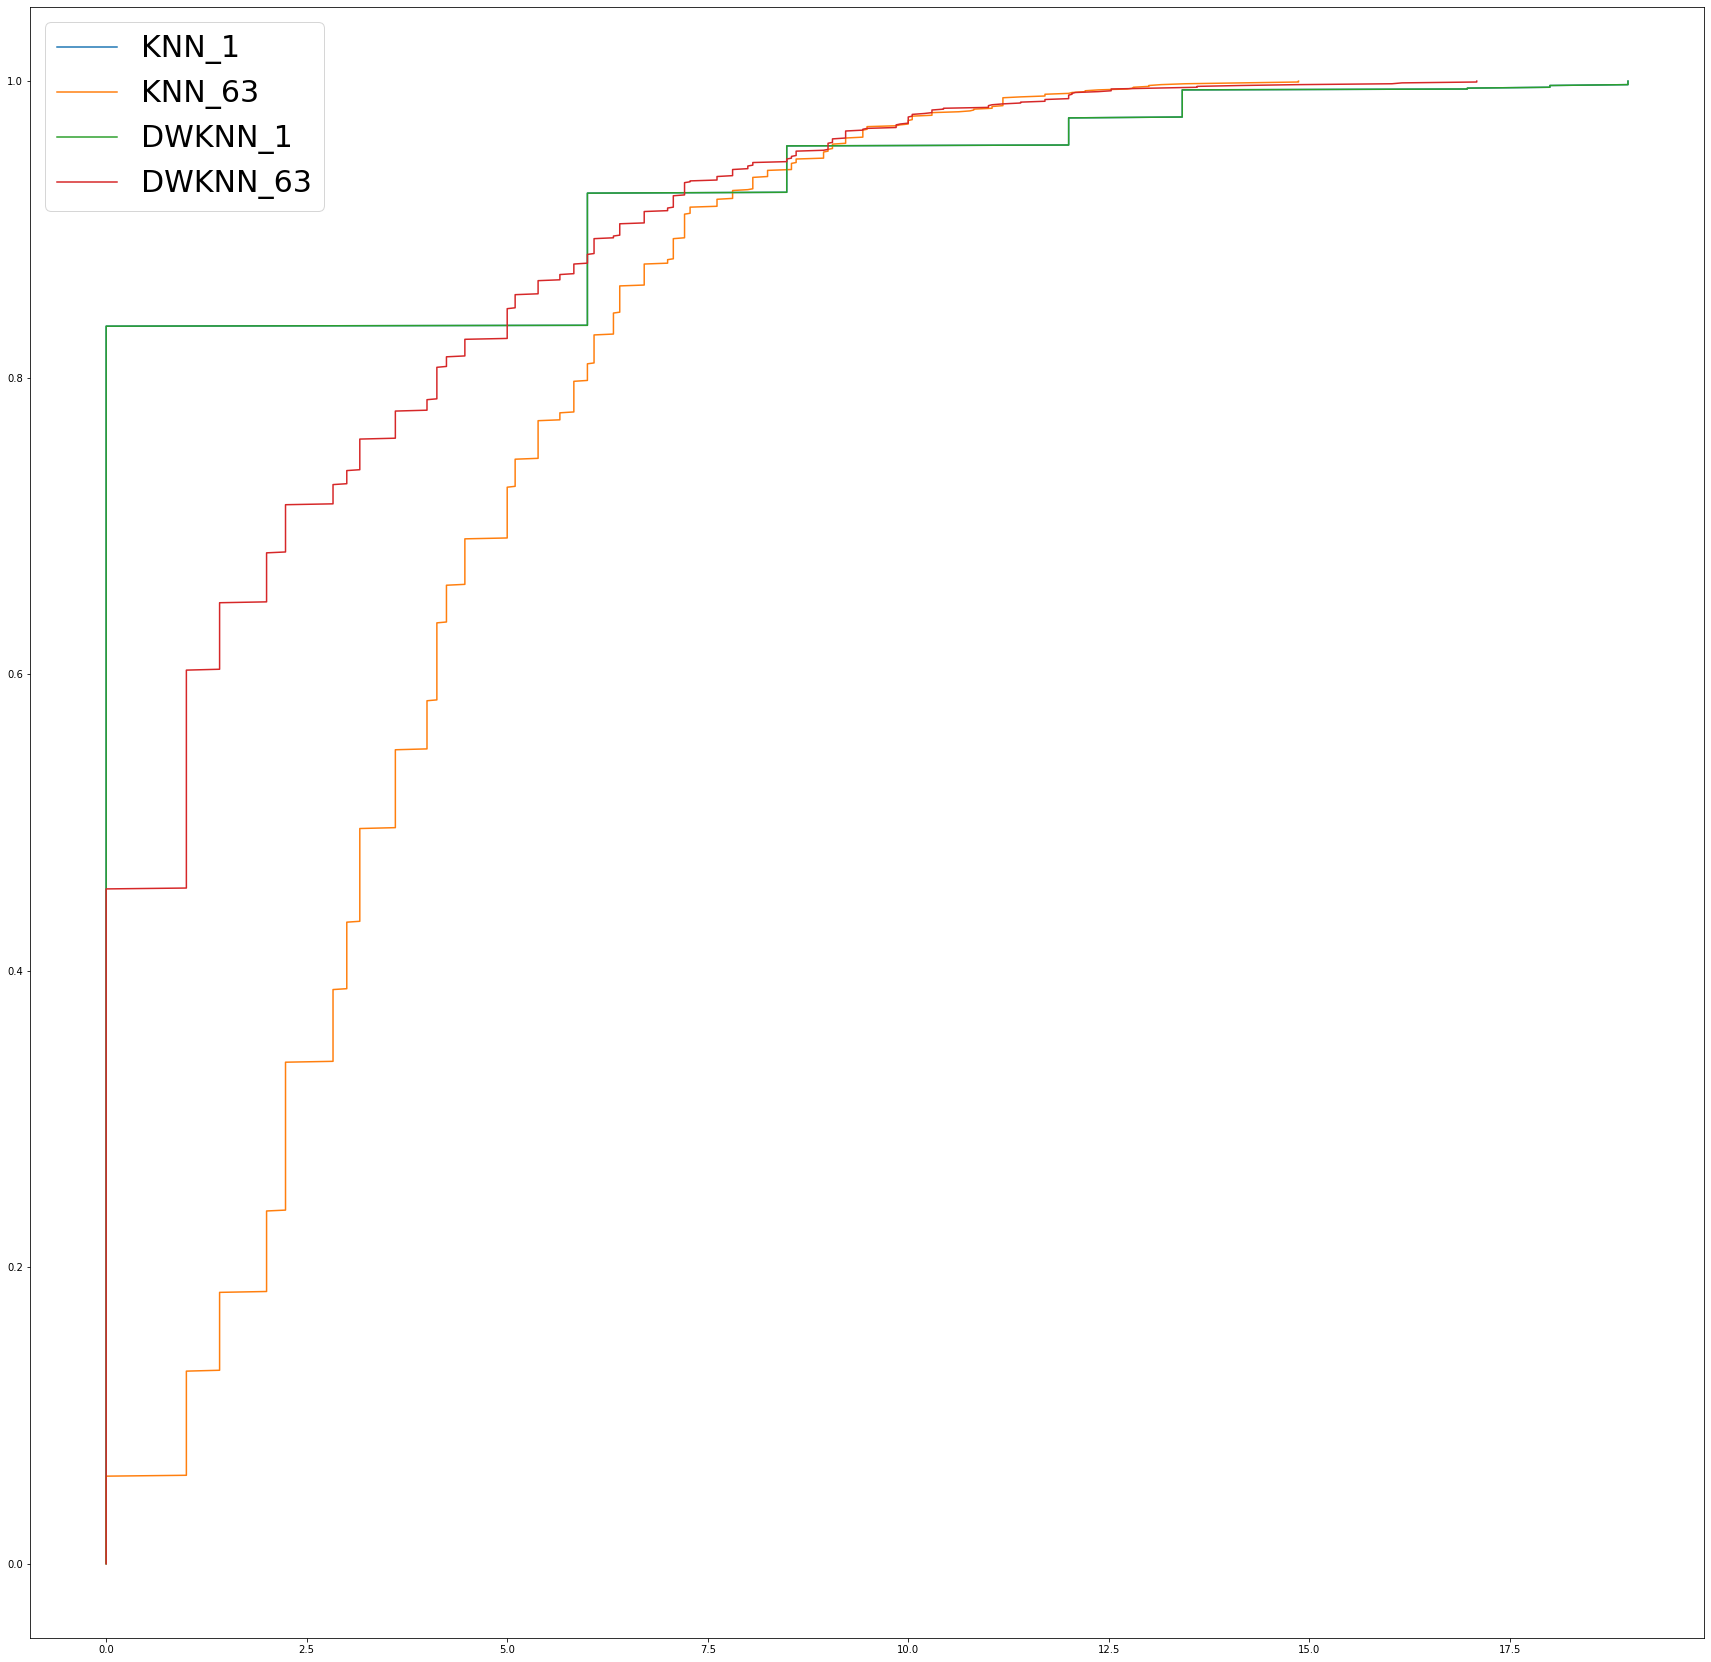

In [29]:
kvalList = [1 , 15, 31, 63]
KNN_kcomp1File = ('E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(kvalList[0])+'.csv')
KNN_kcomp2File = ('E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(kvalList[1])+'.csv')
KNN_kcomp3File = ('E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(kvalList[2])+'.csv')
KNN_kcomp4File = ('E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(kvalList[3])+'.csv')

DWKNN_kcomp1File = ('E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(kvalList[0])+'.csv')
DWKNN_kcomp2File = ('E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(kvalList[1])+'.csv')
DWKNN_kcomp3File = ('E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(kvalList[2])+'.csv')
DWKNN_kcomp4File = ('E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(kvalList[3])+'.csv')

print("Plotting from...")
print(KNN_kcomp1File, KNN_kcomp2File, KNN_kcomp3File, KNN_kcomp4File)
print(DWKNN_kcomp1File, DWKNN_kcomp2File, DWKNN_kcomp3File, DWKNN_kcomp4File)


fig= plt.figure(figsize=(30,30))
errorDf = pd.DataFrame(index = range(0,len(X_test)))

KNN_kcomp1 = pd.read_csv(KNN_kcomp1File)
error = KNN_kcomp1['error']
errorDf["knn_k"+str(kvalList[0])+"_error"] = error
knn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp1_error),step=1)/(len(knn_kcomp1_error)-1)
## plotting    
plt.plot(knn_kcomp1_error,cdf, label = "KNN_1")


KNN_kcomp4 = pd.read_csv(KNN_kcomp4File)
error = KNN_kcomp4['error']
errorDf["knn_k"+str(kvalList[3])+"_error"] = error
knn_kcomp4_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp4_error),step=1)/(len(knn_kcomp4_error)-1)
## plotting    
plt.plot(knn_kcomp4_error,cdf, label = "KNN_63")

#-------------

DWKNN_kcomp1 = pd.read_csv(DWKNN_kcomp1File)
error = DWKNN_kcomp1['error']
errorDf["dwknn_k"+str(kvalList[3])+"_error"] = error
dwknn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp1_error),step=1)/(len(dwknn_kcomp1_error)-1)
## plotting    
plt.plot(dwknn_kcomp1_error,cdf, label = "DWKNN_1")


DWKNN_kcomp4 = pd.read_csv(DWKNN_kcomp4File)
error = DWKNN_kcomp4['error']
errorDf["dwknn_k"+str(kvalList[3])+"_error"] = error
dwknn_kcomp4_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp4_error),step=1)/(len(dwknn_kcomp4_error)-1)
## plotting    
plt.plot(dwknn_kcomp4_error,cdf, label = "DWKNN_63")


# additional plot params
plt.legend(loc='best', fontsize = 30)
plt.show()


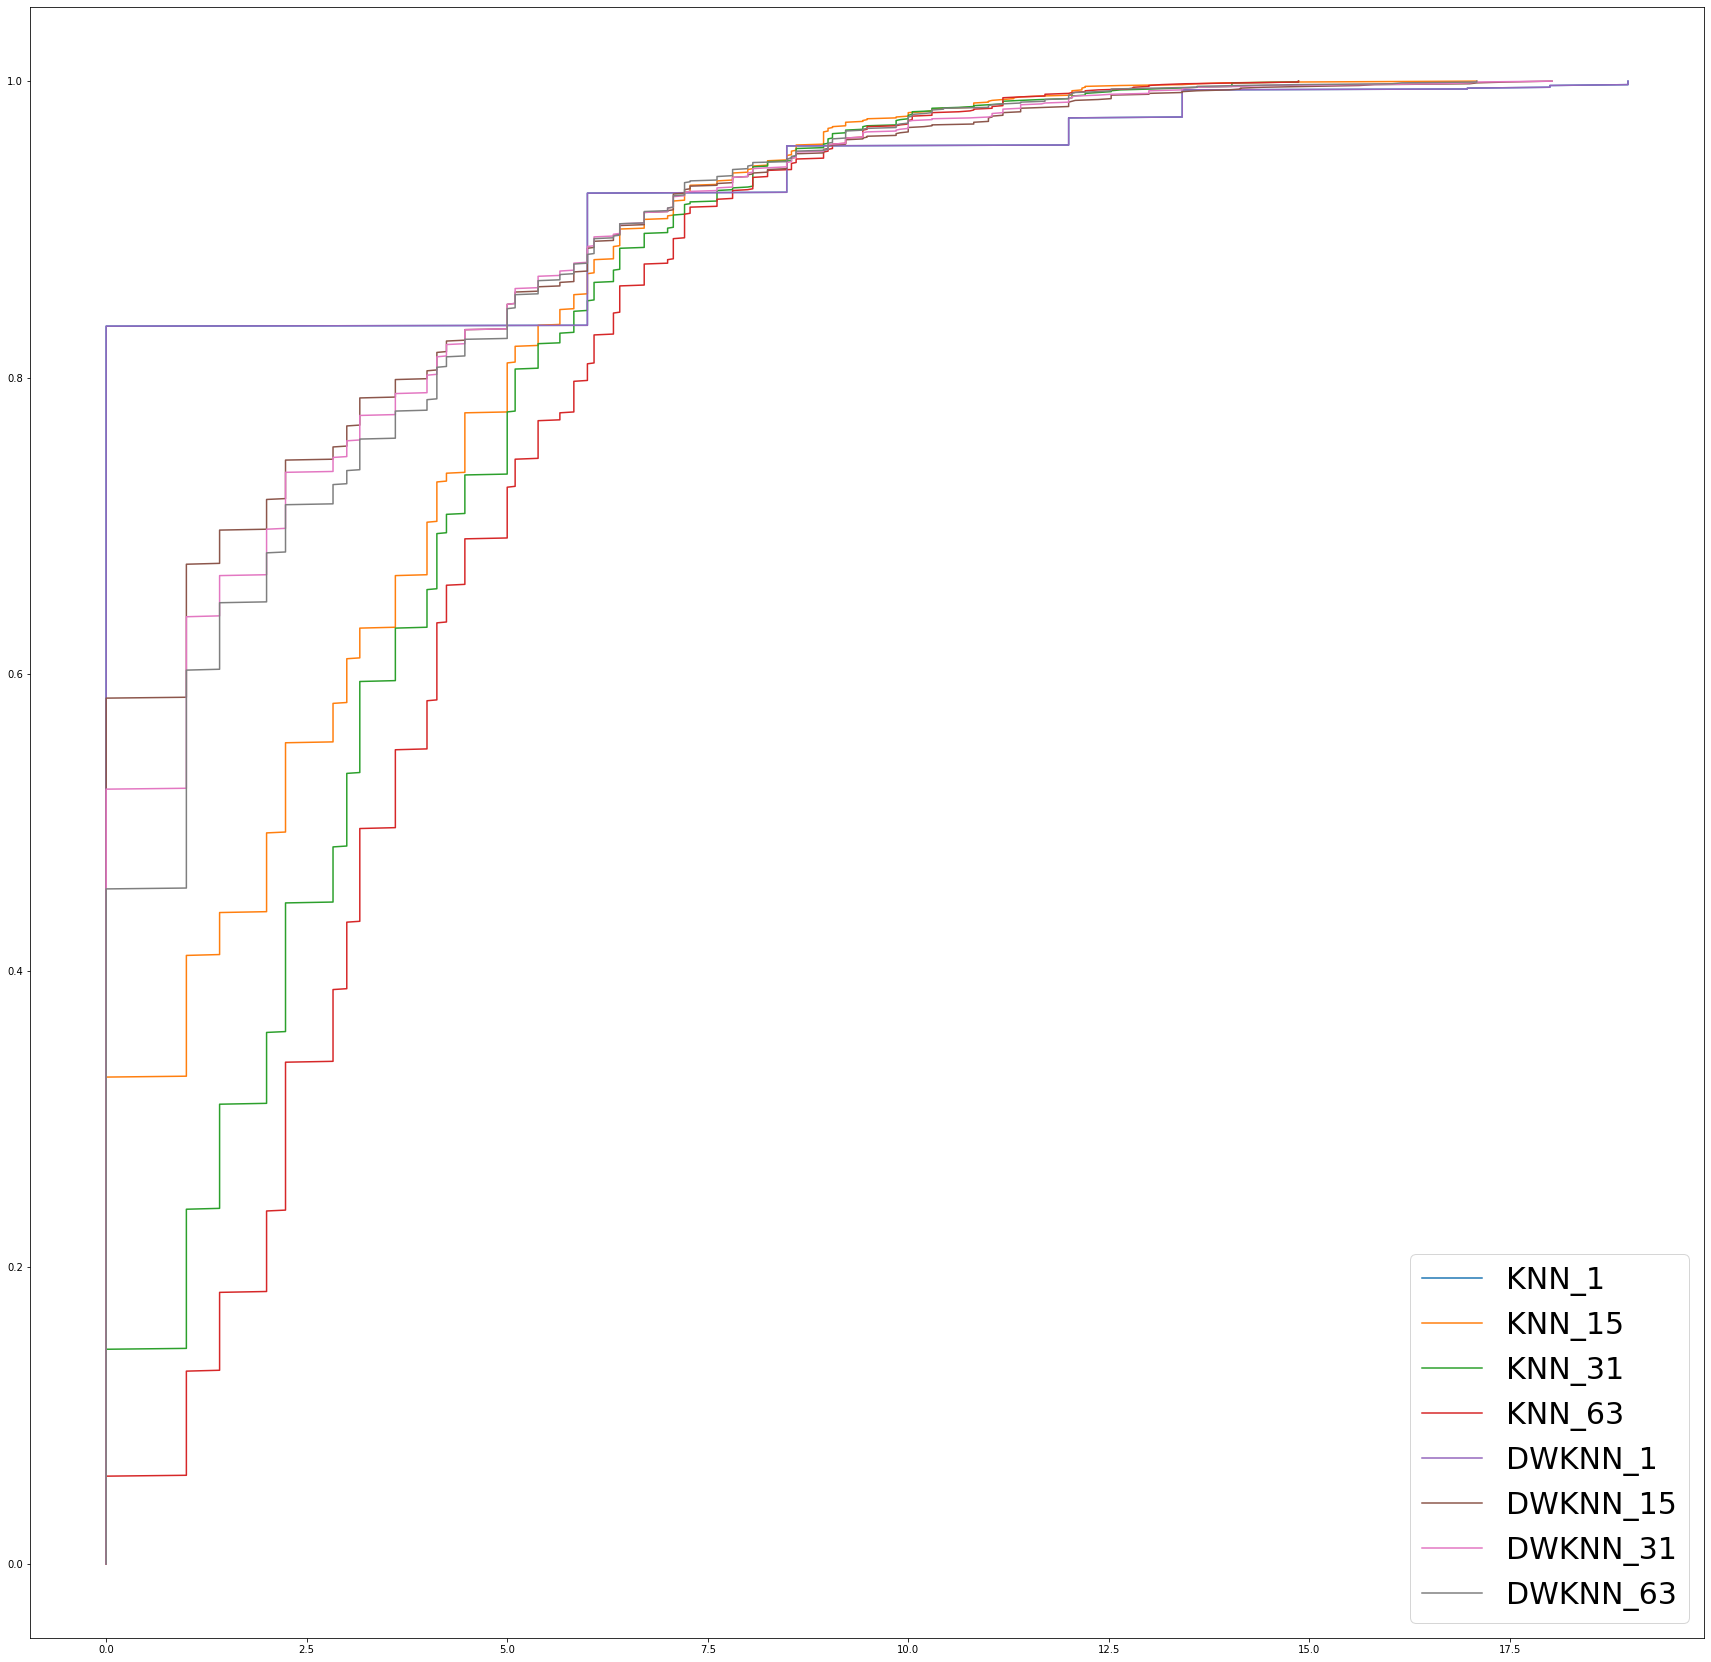

In [30]:
fig= plt.figure(figsize=(30,30))
errorDf = pd.DataFrame(index = range(0,len(X_test)))

KNN_kcomp1 = pd.read_csv(KNN_kcomp1File)
error = KNN_kcomp1['error']
errorDf["knn_k"+str(kvalList[0])+"_error"] = error
knn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp1_error),step=1)/(len(knn_kcomp1_error)-1)
## plotting    
plt.plot(knn_kcomp1_error,cdf, label = "KNN_1")

KNN_kcomp2 = pd.read_csv(KNN_kcomp2File)
error = KNN_kcomp2['error']
errorDf["knn_k"+str(kvalList[1])+"_error"] = error
knn_kcomp2_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp2_error),step=1)/(len(knn_kcomp2_error)-1)
## plotting    
plt.plot(knn_kcomp2_error,cdf, label = "KNN_15")

KNN_kcomp3 = pd.read_csv(KNN_kcomp3File)
error = KNN_kcomp3['error']
errorDf["knn_k"+str(kvalList[2])+"_error"] = error
knn_kcomp3_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp3_error),step=1)/(len(knn_kcomp3_error)-1)
## plotting    
plt.plot(knn_kcomp3_error,cdf, label = "KNN_31")

KNN_kcomp4 = pd.read_csv(KNN_kcomp4File)
error = KNN_kcomp4['error']
errorDf["knn_k"+str(kvalList[3])+"_error"] = error
knn_kcomp4_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp4_error),step=1)/(len(knn_kcomp4_error)-1)
## plotting    
plt.plot(knn_kcomp4_error,cdf, label = "KNN_63")

#-------------

DWKNN_kcomp1 = pd.read_csv(DWKNN_kcomp1File)
error = DWKNN_kcomp1['error']
errorDf["dwknn_k"+str(kvalList[0])+"_error"] = error
dwknn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp1_error),step=1)/(len(dwknn_kcomp1_error)-1)
## plotting    
plt.plot(dwknn_kcomp1_error,cdf, label = "DWKNN_1")

DWKNN_kcomp2 = pd.read_csv(DWKNN_kcomp2File)
error = DWKNN_kcomp2['error']
errorDf["dwknn_k"+str(kvalList[1])+"_error"] = error
dwknn_kcomp2_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp2_error),step=1)/(len(dwknn_kcomp2_error)-1)
## plotting    
plt.plot(dwknn_kcomp2_error,cdf, label = "DWKNN_15")

DWKNN_kcomp3 = pd.read_csv(DWKNN_kcomp3File)
error = DWKNN_kcomp3['error']
errorDf["dwknn_k"+str(kvalList[2])+"_error"] = error
dwknn_kcomp3_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp3_error),step=1)/(len(dwknn_kcomp3_error)-1)
## plotting    
plt.plot(dwknn_kcomp3_error,cdf, label = "DWKNN_31")

DWKNN_kcomp4 = pd.read_csv(DWKNN_kcomp4File)
error = DWKNN_kcomp4['error']
errorDf["dwknn_k"+str(kvalList[3])+"_error"] = error
dwknn_kcomp4_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp4_error),step=1)/(len(dwknn_kcomp4_error)-1)
## plotting    
plt.plot(dwknn_kcomp4_error,cdf, label = "DWKNN_63")


# additional plot params
plt.legend(loc='best', fontsize = 30)
plt.show()


Median Error:
knn_k1_error       0.000000
knn_k15_error      2.236068
knn_k31_error      3.000000
knn_k63_error      3.605551
dwknn_k1_error     0.000000
dwknn_k15_error    0.000000
dwknn_k31_error    0.000000
dwknn_k63_error    1.000000
dtype: float64

0.75 Quantile ERROR:
knn_k1_error       0.000000
knn_k15_error      4.472136
knn_k31_error      5.000000
knn_k63_error      5.385165
dwknn_k1_error     0.000000
dwknn_k15_error    2.828427
dwknn_k31_error    3.000000
dwknn_k63_error    3.162278
Name: 0.75, dtype: float64

Max Error:
knn_k1_error       18.973666
knn_k15_error      17.088007
knn_k31_error      14.866069
knn_k63_error      14.866069
dwknn_k1_error     18.973666
dwknn_k15_error    18.027756
dwknn_k31_error    18.027756
dwknn_k63_error    17.088007
dtype: float64


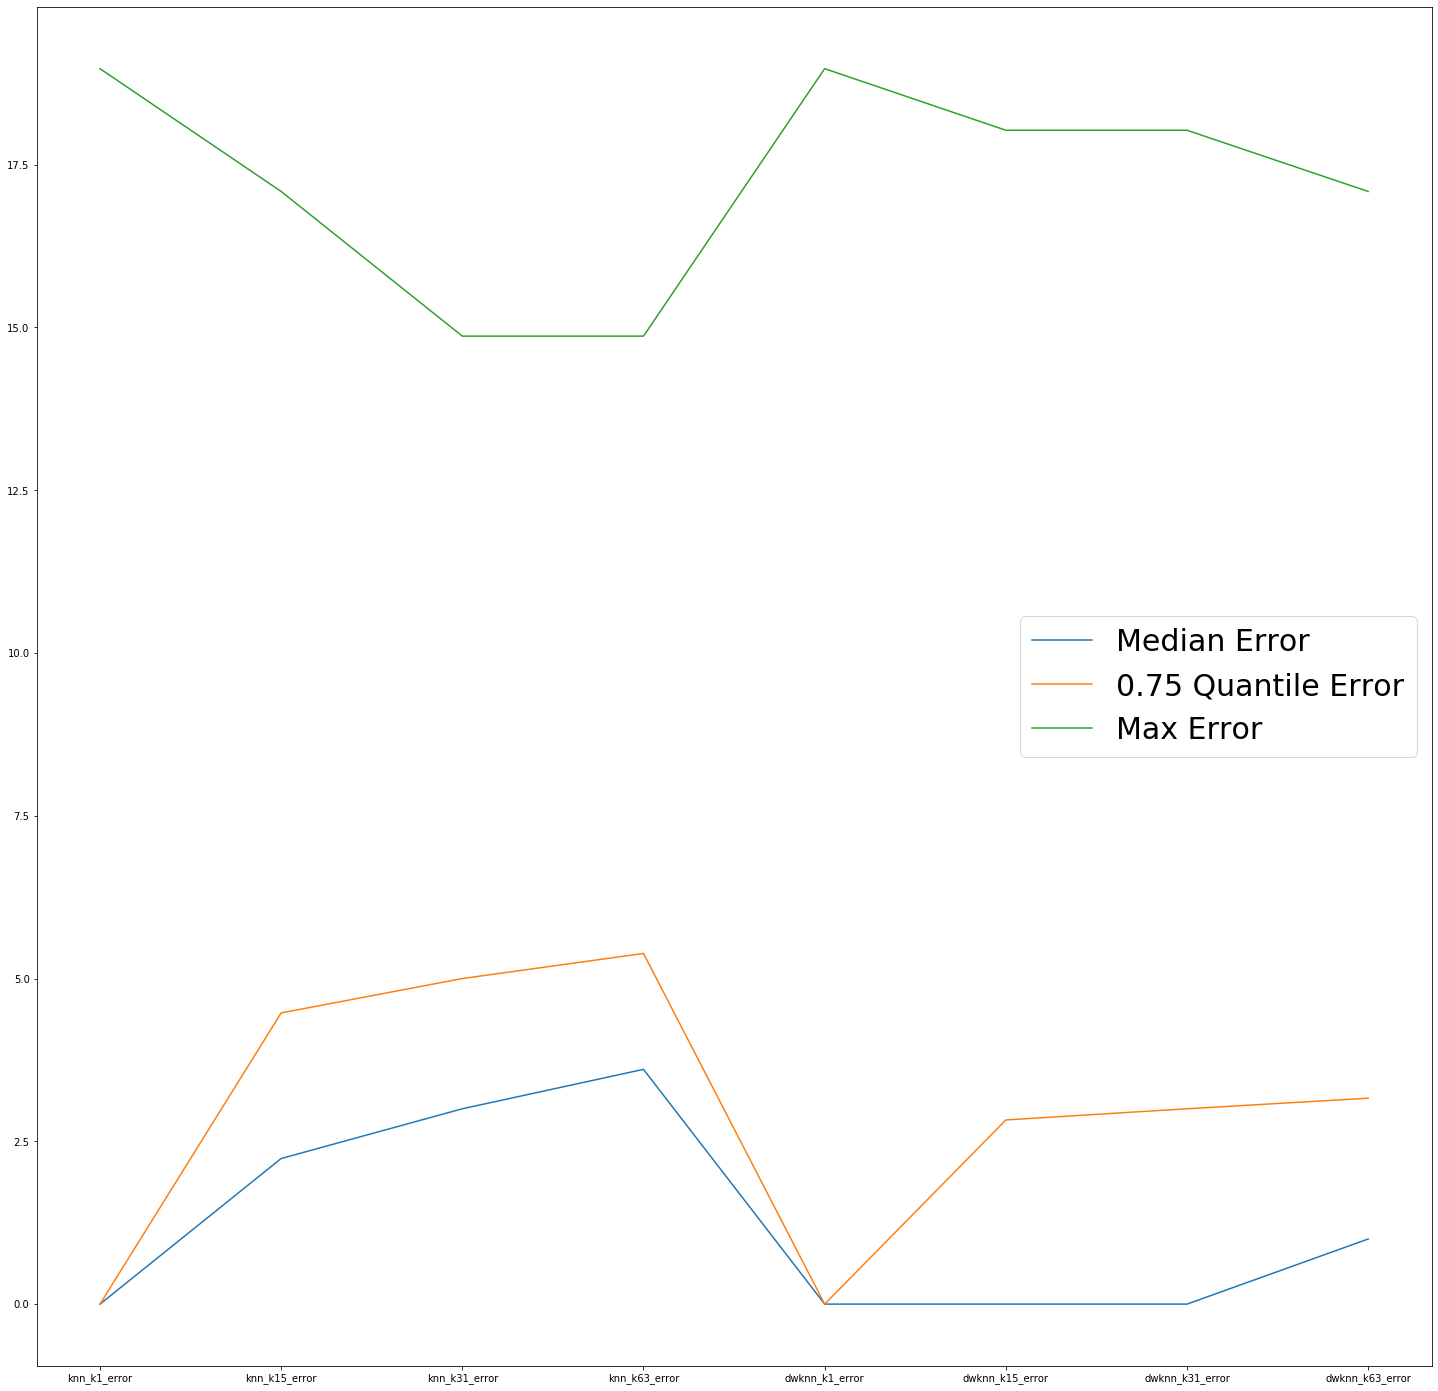

In [31]:
plt.figure(figsize = (25,25))
print("Median Error:")
print(errorDf.median())
plt.plot(errorDf.median(), label = "Median Error")
print("\n0.75 Quantile ERROR:")
print(errorDf.quantile(0.75))
plt.plot(errorDf.quantile(0.75), label = "0.75 Quantile Error")

print("\nMax Error:")
print(errorDf.max())
plt.plot(errorDf.max(), label = "Max Error")

plt.legend(loc = 'best', fontsize = 30)
plt.show()

In [32]:
# Create Error File
writeErrSumm = True
fileNameErrSumm = ('E'+str(exp)+'_ErrSummary_T'+str(trial)+'.csv')
meanErrArr = []
medianErrArr = []
quantErrArr = []
maxErrArr = []
for series in errorDf:
    meanErrArr.append(errorDf[series].mean())
    medianErrArr.append(errorDf[series].median())
    quantErrArr.append(errorDf[series].quantile(0.75))
    maxErrArr.append(errorDf[series].max())
    
errorSummary = pd.DataFrame(index=range(0,len(errorDf.columns)))
errorSummary.insert(loc=0, column="Mean Error", value=meanErrArr)
errorSummary.insert(loc=1, column="Median Error", value=medianErrArr)
errorSummary.insert(loc=2, column="0.75 Quantile Error", value=quantErrArr)
errorSummary.insert(loc=3, column="Max Error", value=maxErrArr)
algoType = ["knn_k"+str(kvalList[0]), "knn_k"+str(kvalList[1]), "knn_k"+str(kvalList[2]), "knn_k"+str(kvalList[3]),
                "dwknn_k"+str(kvalList[0]), "dwknn_k"+str(kvalList[1]), "dwknn_k"+str(kvalList[2]), "dwknn_k"+str(kvalList[3])]

errorSummary.insert(loc=0, column="Algorithm", value = algoType)
print(errorSummary)


if (writeErrSumm == True):
    errorSummary.to_csv(fileNameErrSumm, index=False)
    print("File "+fileNameErrSumm+" has been written.")
# print(medianErrArr)

   Algorithm  Mean Error  Median Error  0.75 Quantile Error  Max Error
0     knn_k1    1.396071      0.000000             0.000000  18.973666
1    knn_k15    2.763488      2.236068             4.472136  17.088007
2    knn_k31    3.339234      3.000000             5.000000  14.866069
3    knn_k63    3.890698      3.605551             5.385165  14.866069
4   dwknn_k1    1.396071      0.000000             0.000000  18.973666
5  dwknn_k15    1.856585      0.000000             2.828427  18.027756
6  dwknn_k31    1.953374      0.000000             3.000000  18.027756
7  dwknn_k63    2.066818      1.000000             3.162278  17.088007
File E4_ErrSummary_T6.csv has been written.
